# Underwater Image restoration model based on a Super Resolution Convolutional Neural Network


## Setup

In [2]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [3]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape, concatenate, Activation
from tensorflow.keras.layers import BatchNormalization, RepeatVector, Permute
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import MaxPooling2D, Input, Dense, Flatten

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec

from skimage.metrics import structural_similarity as ssim

## Load dataset

In [4]:
data_dir = r"C:/Users/Administrator/Desktop/Dataset"
root_dir = os.path.join(data_dir, "UnderwaterImageDataset")

In [5]:
print(data_dir)
print(root_dir)

C:/Users/Administrator/Desktop/Dataset
C:/Users/Administrator/Desktop/Dataset\UnderwaterImageDataset


Create training and validation datasets via `image_dataset_from_directory`.

`image_dataset_from_directory` explained: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [5]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 1186 files belonging to 1 classes.
Using 949 files for training.
Found 1186 files belonging to 1 classes.
Using 237 files for validation.


Rescale the images to take values in the range [0, 1].

In [7]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Visualize a few sample images:

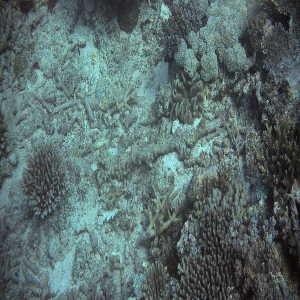

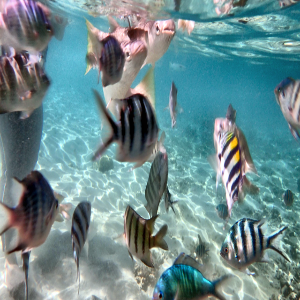

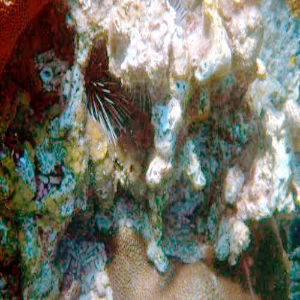

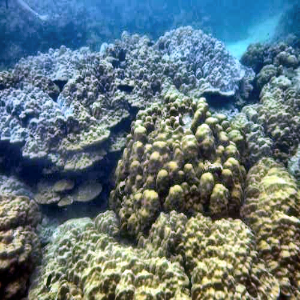

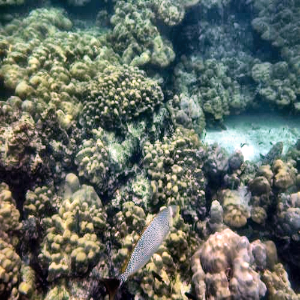

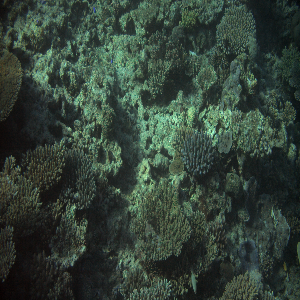

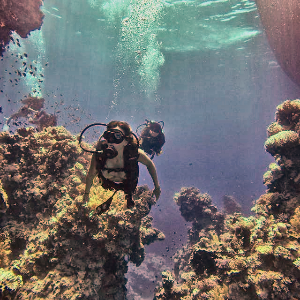

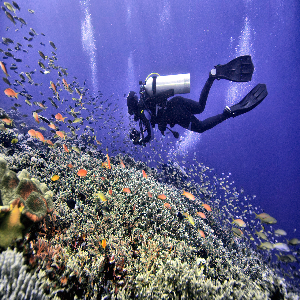

In [9]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

Prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.

In [10]:
dataset = os.path.join(root_dir)
test_path = os.path.join(dataset, "Test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

## Crop and resize images

Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).

For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.

For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.

In [11]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Visualise input and target data.

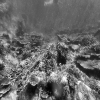

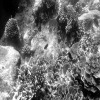

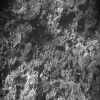

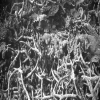

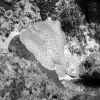

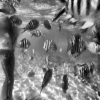

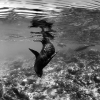

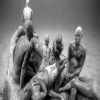

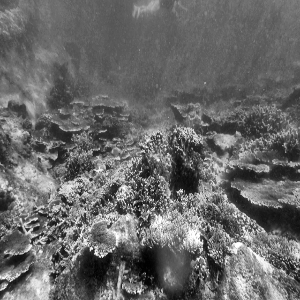

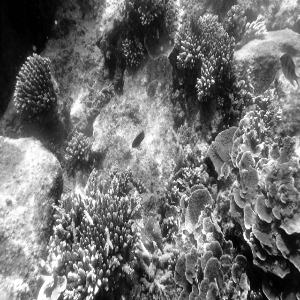

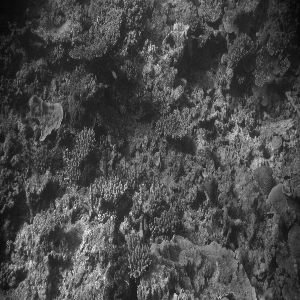

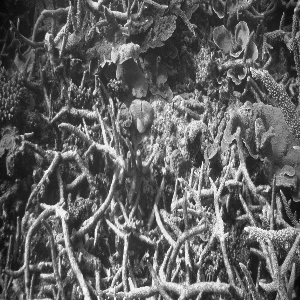

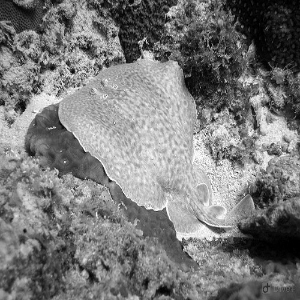

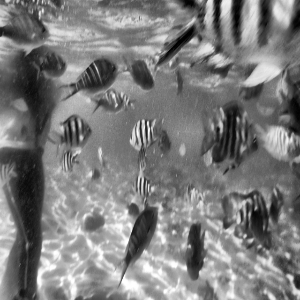

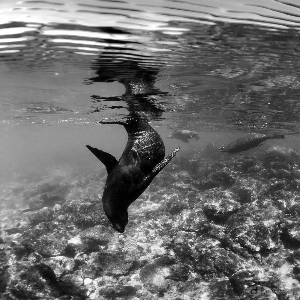

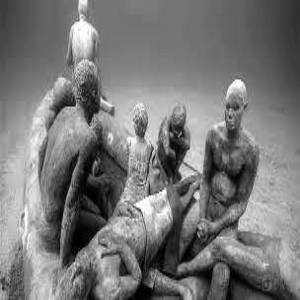

In [13]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

## Build a model

In [62]:
def get_model(upscale_factor=3, channels=1):
    
    inputs = keras.Input(shape=(None, None, channels))
    
    x = UpSampling2D(upscale_factor, interpolation='bilinear')(inputs)
    
    C1 = Conv2D(64,(9,9),padding='SAME',activation='relu', kernel_initializer='Orthogonal')(x)

    C2 = Conv2DTranspose(32,(3,3),padding='SAME',activation='relu', kernel_initializer='Orthogonal')(C1)

    outputs = Conv2DTranspose(1,(5,5),padding='SAME', activation='relu', kernel_initializer='Orthogonal')(C2)


    return keras.Model(inputs, outputs)


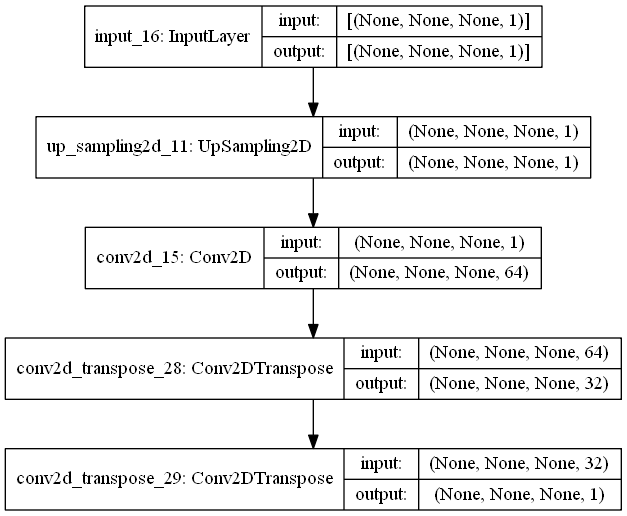

In [64]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='dsrcnn_model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='dsrcnn_model_.png')

## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [66]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


Define `ModelCheckpoint` and `EarlyStopping` callbacks.

In [67]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = r"C:/Users\Administrator\Desktop\UCT\4th year\EEE4022S\FinalModels\Results\DDSRCNN-results-SISR"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, None, None, 1)     801       
Total params: 24,513
Trainable params: 24,513
Non-trainable params: 0
_________________________________________________________________


## Train the model

Epoch 1/100
119/119 - 13s - loss: 0.0644 - val_loss: 0.0068
Mean PSNR for epoch: 21.39


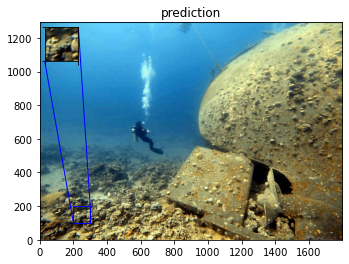

Epoch 2/100
119/119 - 13s - loss: 0.0056 - val_loss: 0.0057
Mean PSNR for epoch: 22.41
Epoch 3/100
119/119 - 13s - loss: 0.0045 - val_loss: 0.0047
Mean PSNR for epoch: 23.19
Epoch 4/100
119/119 - 13s - loss: 0.0044 - val_loss: 0.0047
Mean PSNR for epoch: 23.17
Epoch 5/100
119/119 - 13s - loss: 0.0043 - val_loss: 0.0046
Mean PSNR for epoch: 23.15
Epoch 6/100
119/119 - 13s - loss: 0.0043 - val_loss: 0.0046
Mean PSNR for epoch: 23.16
Epoch 7/100
119/119 - 13s - loss: 0.0043 - val_loss: 0.0046
Mean PSNR for epoch: 23.26
Epoch 8/100
119/119 - 13s - loss: 0.0042 - val_loss: 0.0039
Mean PSNR for epoch: 23.82
Epoch 9/100
119/119 - 13s - loss: 0.0035 - val_loss: 0.0037
Mean PSNR for epoch: 24.06
Epoch 10/100
119/119 - 13s - loss: 0.0035 - val_loss: 0.0037
Mean PSNR for epoch: 24.30
Epoch 11/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0037
Mean PSNR for epoch: 24.22
Epoch 12/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0037
Mean PSNR for epoch: 24.18
Epoch 13/100
119/119 - 13s - loss: 0.003

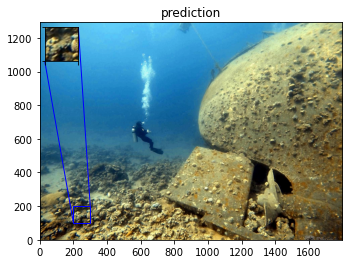

Epoch 22/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.38
Epoch 23/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.22
Epoch 24/100
119/119 - 15s - loss: 0.0036 - val_loss: 0.0038
Mean PSNR for epoch: 23.87
Epoch 25/100
119/119 - 14s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 23.99
Epoch 26/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.19
Epoch 27/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.16
Epoch 28/100
119/119 - 15s - loss: 0.0034 - val_loss: 0.0037
Mean PSNR for epoch: 24.22
Epoch 29/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 23.88
Epoch 30/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.24
Epoch 31/100
119/119 - 14s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.35
Epoch 32/100
119/119 - 13s - loss: 0.0038 - val_loss: 0.0036
Mean PSNR for epoch: 24.09
Epoch 33/100
119/119 - 13s - los

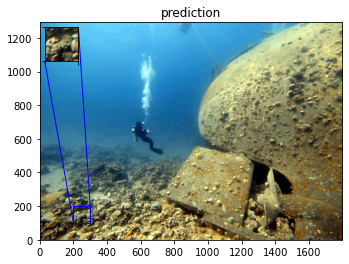

Epoch 42/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.03
Epoch 43/100
119/119 - 13s - loss: 0.0036 - val_loss: 0.0036
Mean PSNR for epoch: 24.23
Epoch 44/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.24
Epoch 45/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.37
Epoch 46/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.25
Epoch 47/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.16
Epoch 48/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.32
Epoch 49/100
119/119 - 14s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.29
Epoch 50/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.11
Epoch 51/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.20
Epoch 52/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.17
Epoch 53/100
119/119 - 13s - los

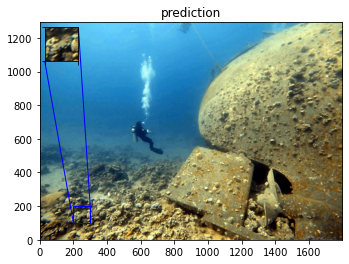

Epoch 62/100
119/119 - 13s - loss: 0.0036 - val_loss: 0.0036
Mean PSNR for epoch: 24.01
Epoch 63/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.34
Epoch 64/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.45
Epoch 65/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.48
Epoch 66/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.21
Epoch 67/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.21
Epoch 68/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.12
Epoch 69/100
119/119 - 15s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.63
Epoch 70/100
119/119 - 15s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.24
Epoch 71/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.05
Epoch 72/100
119/119 - 13s - loss: 0.0033 - val_loss: 0.0036
Mean PSNR for epoch: 24.04
Epoch 73/100
119/119 - 13s - los

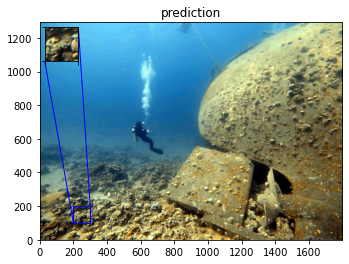

Epoch 82/100
119/119 - 13s - loss: 0.0034 - val_loss: 0.0036
Mean PSNR for epoch: 24.22


In [68]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

## Run model prediction and plot the results

Let's compute the reconstructed version of a few images and save the results.

In [69]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


PSNR of low resolution image and high resolution image is 39.3084
PSNR of predict and high resolution is 38.1835
MSE of low resolution image and high resolution image is 22.8752
MSE of predict and high resolution is 29.6383
SSIM of low resolution image and high resolution image is 0.6929
SSIM of predict and high resolution is 0.7172


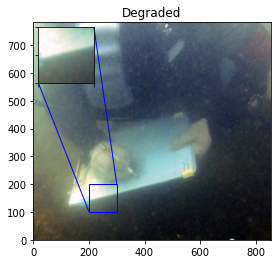

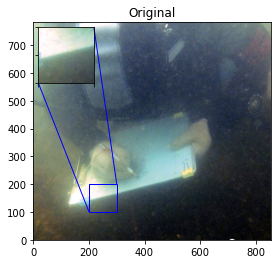

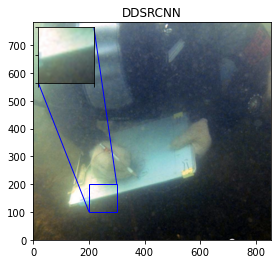

PSNR of low resolution image and high resolution image is 32.5917
PSNR of predict and high resolution is 32.8184
MSE of low resolution image and high resolution image is 107.4061
MSE of predict and high resolution is 101.9449
SSIM of low resolution image and high resolution image is 0.7737
SSIM of predict and high resolution is 0.7609


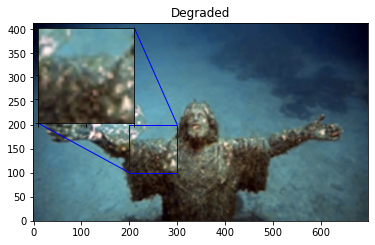

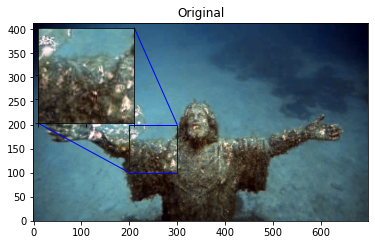

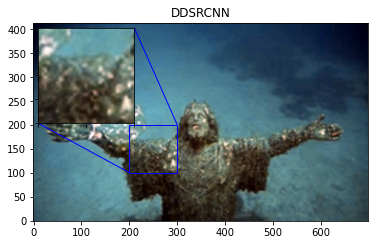

PSNR of low resolution image and high resolution image is 24.7760
PSNR of predict and high resolution is 25.3239
MSE of low resolution image and high resolution image is 649.5361
MSE of predict and high resolution is 572.5452
SSIM of low resolution image and high resolution image is 0.6625
SSIM of predict and high resolution is 0.7098


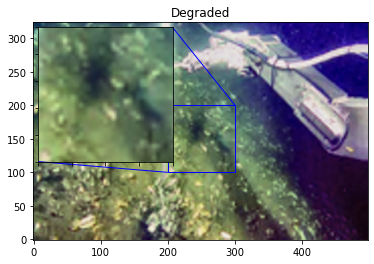

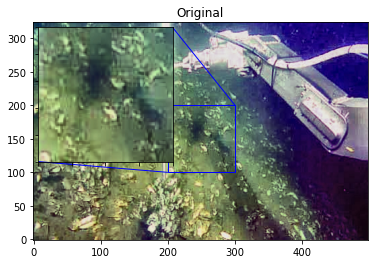

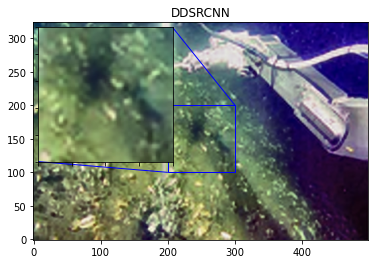

PSNR of low resolution image and high resolution image is 32.5009
PSNR of predict and high resolution is 32.6918
MSE of low resolution image and high resolution image is 109.6758
MSE of predict and high resolution is 104.9606
SSIM of low resolution image and high resolution image is 0.6094
SSIM of predict and high resolution is 0.6443


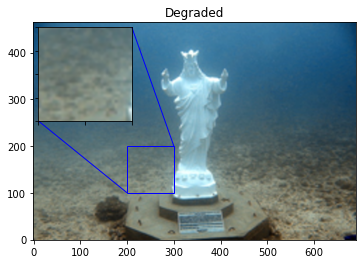

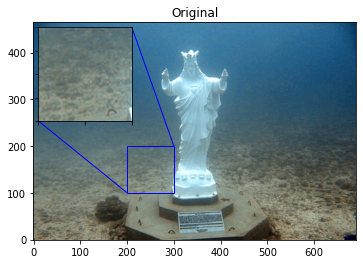

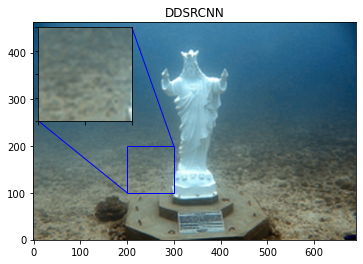

PSNR of low resolution image and high resolution image is 31.3856
PSNR of predict and high resolution is 31.9992
MSE of low resolution image and high resolution image is 141.7885
MSE of predict and high resolution is 123.1057
SSIM of low resolution image and high resolution image is 0.6993
SSIM of predict and high resolution is 0.6785


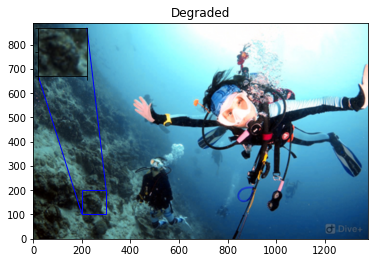

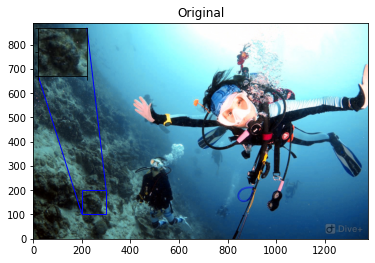

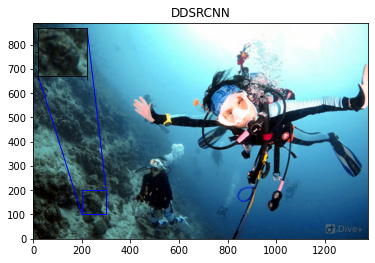

PSNR of low resolution image and high resolution image is 26.5757
PSNR of predict and high resolution is 27.3341
MSE of low resolution image and high resolution image is 429.1703
MSE of predict and high resolution is 360.4050
SSIM of low resolution image and high resolution image is 0.7244
SSIM of predict and high resolution is 0.7624


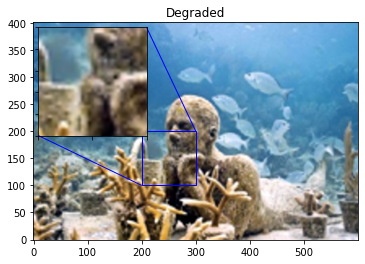

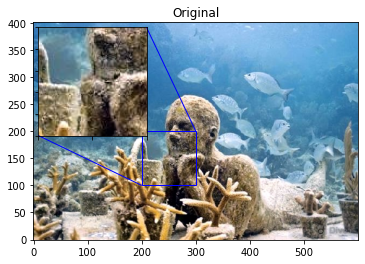

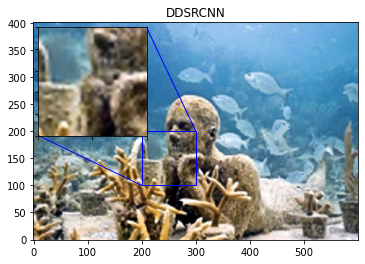

PSNR of low resolution image and high resolution image is 27.1909
PSNR of predict and high resolution is 27.7792
MSE of low resolution image and high resolution image is 372.4896
MSE of predict and high resolution is 325.2987
SSIM of low resolution image and high resolution image is 0.6943
SSIM of predict and high resolution is 0.7133


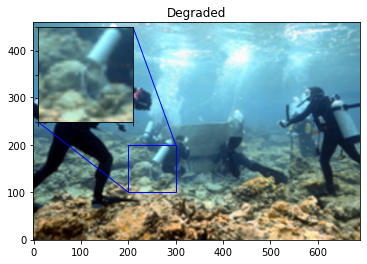

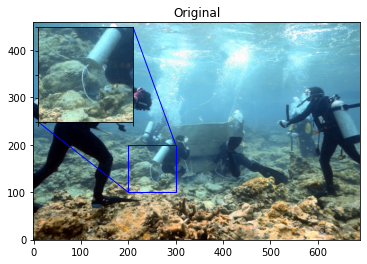

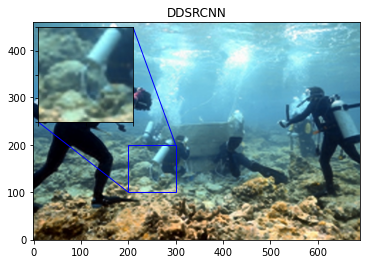

PSNR of low resolution image and high resolution image is 23.3551
PSNR of predict and high resolution is 23.7106
MSE of low resolution image and high resolution image is 900.9407
MSE of predict and high resolution is 830.1123
SSIM of low resolution image and high resolution image is 0.5981
SSIM of predict and high resolution is 0.6344


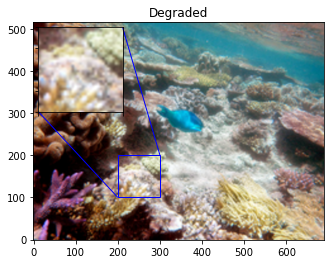

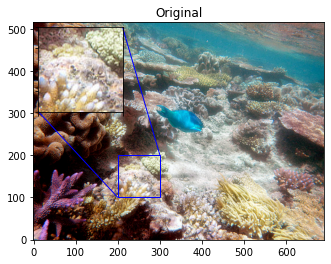

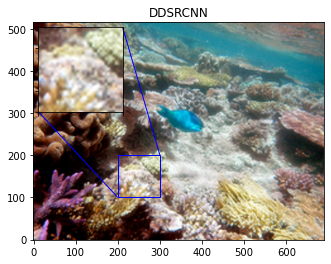

PSNR of low resolution image and high resolution image is 33.8692
PSNR of predict and high resolution is 34.5531
MSE of low resolution image and high resolution image is 80.0345
MSE of predict and high resolution is 68.3741
SSIM of low resolution image and high resolution image is 0.7362
SSIM of predict and high resolution is 0.7163


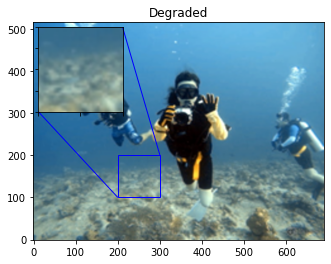

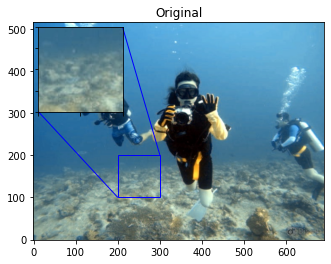

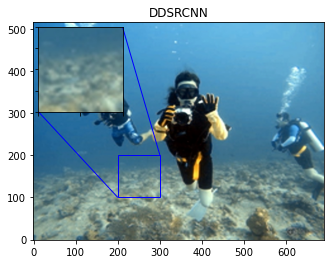

PSNR of low resolution image and high resolution image is 27.2364
PSNR of predict and high resolution is 27.9301
MSE of low resolution image and high resolution image is 368.6031
MSE of predict and high resolution is 314.1879
SSIM of low resolution image and high resolution image is 0.7338
SSIM of predict and high resolution is 0.7559


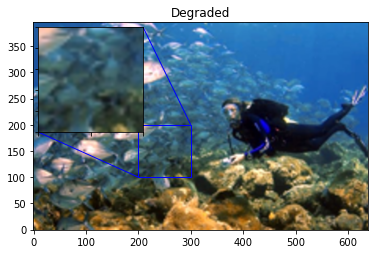

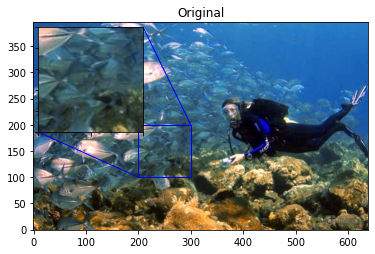

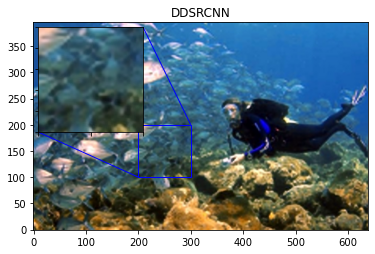

Avg. PSNR of lowres images is 29.8790
Avg. PSNR of reconstructions is 30.2324

Avg. MSE of lowres images is 318.2520
Avg. MSE of reconstructions is 283.0573

Avg. SSIM of lowres images is 0.6924
Avg. SSIM of reconstructions is 0.7093


In [70]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

total_bicubic_mse = 0.0
total_test_mse = 0.0

total_bicubic_ssim = 0.0
total_test_ssim = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    
    bicubic_score = compare_images(highres_img_arr, lowres_img_arr)
    test_score = compare_images(highres_img_arr, predict_img_arr)

    total_bicubic_psnr += bicubic_score[0]
    total_test_psnr += test_score[0]
    
    total_bicubic_mse += bicubic_score[1]
    total_test_mse += test_score[1]
    
    total_bicubic_ssim += bicubic_score[2]
    total_test_ssim += test_score[2]

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_score[0]
    )
    print("PSNR of predict and high resolution is %.4f" % test_score[0])
    
    print(
        "MSE of low resolution image and high resolution image is %.4f" % bicubic_score[1]
    )
    print("MSE of predict and high resolution is %.4f" % test_score[1])
    
    print(
        "SSIM of low resolution image and high resolution image is %.4f" % bicubic_score[2]
    )
    print("SSIM of predict and high resolution is %.4f" % test_score[2])
    
    plot_results(lowres_img, index, "Degraded")
    plot_results(highres_img, index, "Original")
    plot_results(prediction, index, "DDSRCNN")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))
print()
print("Avg. MSE of lowres images is %.4f" % (total_bicubic_mse / 10))
print("Avg. MSE of reconstructions is %.4f" % (total_test_mse / 10))
print()
print("Avg. SSIM of lowres images is %.4f" % (total_bicubic_ssim / 10))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 10))